In [ ]:
%pip install -q requests beautifulsoup4

%pip install -q pandas

Note: you may need to restart the kernel to use updated packages.


In [131]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re

BASE_URL = "https://australia.national-lottery.com"
ARCHIVE_URL = BASE_URL + "/powerball/results-archive-{}"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

def fetch_year_results(year: int):
    """Fetch and parse draws for a given year.
    Historic format changes are governed by draw numbers:
      - draw_no <= 876:    5 main numbers + 1 powerball
      - 877 <= draw_no <=1143: 6 main numbers + 1 powerball
      - draw_no >=1144:    7 main numbers + 1 powerball

    If draw_no cannot be parsed for a row, default to the latest format (7 main numbers).
    """
    url = ARCHIVE_URL.format(year)
    print(f"Fetching {year}: {url}")
    resp = requests.get(url, headers=HEADERS, timeout=15)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    # Find the table that contains the archive. Prefer the powerball table class.
    table = soup.select_one('table.powerball') or soup.find('table')
    if table is None:
        print(f"  No table found for year {year}")
        return []

    draws = []
    rows = table.select('tr')
    for row in rows[1:]:  # skip header
        # Use the visible row text separated by ' | '
        row_text = row.get_text(' | ', strip=True)
        parts = [p.strip() for p in row_text.split('|') if p.strip()]

        if not parts:
            continue

        # Skip non-draw rows (e.g. promotional rows)
        if not re.match(r'\s*Draw\b', parts[0], re.I):
            continue

        # Extract draw number
        m = re.search(r'Draw\s*(\d+)', parts[0], re.I)
        draw_no = m.group(1) if m else parts[0]

        # Determine expected_main based on draw_no ranges; if parsing fails, default to latest format (7)
        expected_main = None
        try:
            dn = int(draw_no)
            if dn <= 876:
                expected_main = 5
            elif 877 <= dn <= 1143:
                expected_main = 6
            else:
                expected_main = 7
        except Exception:
            # If draw number can't be parsed, assume latest format (7 main numbers)
            expected_main = 7

        # Date usually in parts[1]
        date = parts[1] if len(parts) > 1 else ''

        # Jackpot (or total winners) is commonly the last part
        jackpot = parts[-1] if len(parts) >= 3 else None

        # Numbers are typically the middle parts (between date and jackpot)
        num_parts = parts[2:-1] if len(parts) > 3 else parts[2:]
        numbers = []
        for p in num_parts:
            # capture any 1-2 digit tokens from the part
            found = re.findall(r"\b\d{1,2}\b", p)
            if found:
                numbers.extend(found)

        # Fallback: if we didn't capture numbers above, extract numeric tokens from whole row_text
        if not numbers:
            tokens = re.findall(r"\b\d{1,2}\b", row_text)
            # tokens may include other numbers; heuristic: take up to expected_main+1 tokens
            numbers = tokens[: expected_main + 1]

        # Decide main numbers and powerball according to expected_main
        main_numbers = []
        powerball = None
        if len(numbers) >= expected_main + 1:
            main_numbers = numbers[:expected_main]
            powerball = numbers[expected_main]
        elif len(numbers) >= expected_main:
            # If we have at least expected_main numbers but no separate powerball, take them as main
            main_numbers = numbers[:expected_main]
            powerball = None
        else:
            # Not enough tokens; keep whatever we have as a best-effort main numbers
            main_numbers = numbers
            powerball = None

        draws.append({
            "year": year,
            "draw_no": draw_no,
            "date": date,
            "numbers": main_numbers,
            "powerball": powerball,
            "jackpot": jackpot,
            "row_text": row_text
        })

    print(f"  Parsed {len(draws)} draws for {year} (expected_main based on draw_no)")
    return draws


def crawl_all_years(start=1996, end=2025):
    all_draws = []
    for year in range(start, end+1):
        print(f"Fetching {year}...")
        try:
            year_results = fetch_year_results(year)
            all_draws.extend(year_results)
        except Exception as e:
            print(f"Failed for {year}: {e}")
        time.sleep(1)  # polite delay
    return all_draws

if __name__ == "__main__":
    results = crawl_all_years(1996, 2025)  # adjust years as needed
    with open("powerball_results.json", "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print("Saved results to powerball_results.json")

Fetching 1996...
Fetching 1996: https://australia.national-lottery.com/powerball/results-archive-1996
  Parsed 32 draws for 1996 (expected_main based on draw_no)
  Parsed 32 draws for 1996 (expected_main based on draw_no)
Fetching 1997...
Fetching 1997: https://australia.national-lottery.com/powerball/results-archive-1997
Fetching 1997...
Fetching 1997: https://australia.national-lottery.com/powerball/results-archive-1997
  Parsed 52 draws for 1997 (expected_main based on draw_no)
  Parsed 52 draws for 1997 (expected_main based on draw_no)
Fetching 1998...
Fetching 1998: https://australia.national-lottery.com/powerball/results-archive-1998
Fetching 1998...
Fetching 1998: https://australia.national-lottery.com/powerball/results-archive-1998
  Parsed 53 draws for 1998 (expected_main based on draw_no)
  Parsed 53 draws for 1998 (expected_main based on draw_no)
Fetching 1999...
Fetching 1999: https://australia.national-lottery.com/powerball/results-archive-1999
Fetching 1999...
Fetching 19

In [132]:
import pandas as pd

df = pd.read_json("powerball_results.json")
df.head()

,year,draw_no,date,numbers,powerball,jackpot,row_text
0,1996,32,1996-12-26,"[5, 8, 15, 19, 24]",3,-,"Draw 32 | 26 December, 1996 | 5 | 8 | 15 | 19 ..."
1,1996,31,1996-12-19,"[6, 10, 12, 22, 27]",38,-,"Draw 31 | 19 December, 1996 | 6 | 10 | 12 | 22..."
2,1996,30,1996-12-12,"[2, 8, 13, 22, 35]",42,-,"Draw 30 | 12 December, 1996 | 2 | 8 | 13 | 22 ..."
3,1996,29,1996-12-05,"[5, 6, 17, 20, 30]",13,-,"Draw 29 | 5 December, 1996 | 5 | 6 | 17 | 20 |..."
4,1996,28,1996-11-28,"[5, 20, 24, 30, 36]",19,-,"Draw 28 | 28 November, 1996 | 5 | 20 | 24 | 30..."


In [133]:
df.shape

(1533, 7)

In [134]:
df.tail()

,year,draw_no,date,numbers,powerball,jackpot,row_text
1528,2025,1498,2025-01-30,"[1, 2, 12, 13, 18, 19, 23]",4,"1,095,672","Draw 1498 | 30 January, 2025 | 1 | 2 | 12 | 13..."
1529,2025,1497,2025-01-23,"[9, 11, 12, 17, 27, 29, 32]",18,"804,805","Draw 1497 | 23 January, 2025 | 9 | 11 | 12 | 1..."
1530,2025,1496,2025-01-16,"[2, 6, 13, 14, 25, 30, 31]",2,"621,694","Draw 1496 | 16 January, 2025 | 2 | 6 | 13 | 14..."
1531,2025,1495,2025-01-09,"[1, 2, 8, 11, 17, 19, 26]",11,"486,641","Draw 1495 | 9 January, 2025 | 1 | 2 | 8 | 11 |..."
1532,2025,1494,2025-01-02,"[8, 9, 15, 18, 21, 22, 27]",19,"866,600","Draw 1494 | 2 January, 2025 | 8 | 9 | 15 | 18 ..."


In [135]:
df7=df[df.draw_no>=1144]

In [136]:
df7.shape

(390, 7)

In [137]:
sum(counts_1_to_35.values())/df7.shape[0]

7.0

In [139]:
from collections import Counter

# Flatten all numbers in the 'numbers' column for 2018+ draws
all_numbers = [int(num) for nums in df7['numbers'] for num in nums]

# Count occurrences for numbers 1 to 35
number_counts = Counter(all_numbers)
counts_1_to_35 = {n: number_counts.get(n, 0) for n in range(1, 36)}
counts_1_to_35

{1: 77,
 2: 81,
 3: 85,
 4: 76,
 5: 75,
 6: 80,
 7: 89,
 8: 71,
 9: 91,
 10: 79,
 11: 86,
 12: 81,
 13: 67,
 14: 84,
 15: 67,
 16: 79,
 17: 89,
 18: 83,
 19: 83,
 20: 80,
 21: 78,
 22: 76,
 23: 85,
 24: 75,
 25: 77,
 26: 68,
 27: 72,
 28: 77,
 29: 68,
 30: 82,
 31: 67,
 32: 84,
 33: 71,
 34: 73,
 35: 74}

In [91]:
%pip install -q matplotlib

Note: you may need to restart the kernel to use updated packages.


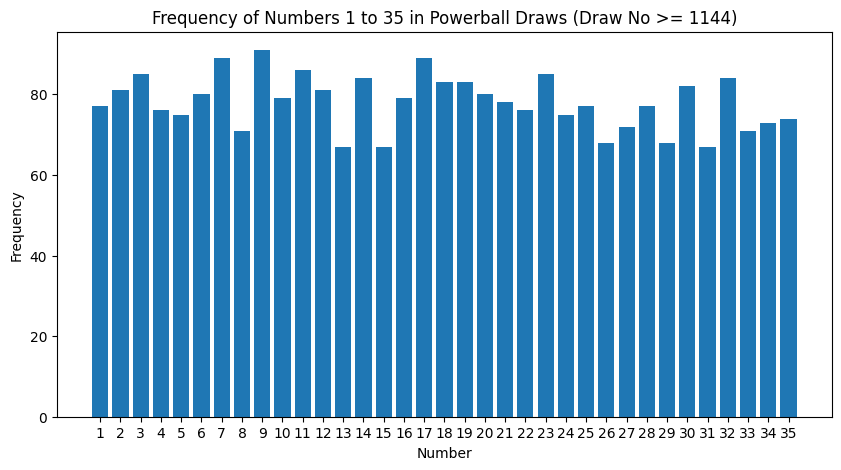

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(counts_1_to_35.keys(), counts_1_to_35.values())
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Frequency of Numbers 1 to 35 in Powerball Draws (Draw No >= 1144)')
plt.xticks(range(1, 36))
plt.show()

In [95]:
%pip install -q scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [101]:
from sklearn.ensemble import RandomForestClassifier

# Train one classifier for each of the 7 numbers (as before)
models = []
y_preds = []
for i in range(7):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train[:, i])
    y_pred_i = clf.predict(X_val)
    models.append(clf)
    y_preds.append(y_pred_i)

# Stack predictions to shape (n_samples, 7)
y_pred_all = np.column_stack(y_preds)

# Set-based accuracy: proportion of predicted numbers that are in the true set (order doesn't matter)
def set_accuracy(y_true, y_pred):
    matches = [len(set(pred) & set(true)) / 7 for pred, true in zip(y_pred, y_true)]
    return sum(matches) / len(matches)

acc_set = set_accuracy(y_val, y_pred_all)
print(f"Set-based accuracy: {acc_set:.3f}")

Set-based accuracy: 0.174


In [113]:
for pred, true in zip(y_pred_all, y_val):
    pred_set = set(int(x) for x in pred)
    true_set = set(int(x) for x in true)
    matched = sorted(pred_set & true_set)
    accuracy = len(pred_set & true_set) / len(true_set)
    print(f"Predicted: {sorted(pred_set)} | True: {sorted(true_set)} | Accuracy: {accuracy:.2f} | Matched: {matched}")

Predicted: [1, 9, 11, 22, 25, 31, 35] | True: [7, 10, 12, 16, 17, 20, 28] | Accuracy: 0.00 | Matched: []
Predicted: [5, 7, 9, 11, 21, 25, 35] | True: [2, 5, 8, 17, 20, 24, 27] | Accuracy: 0.14 | Matched: [5]
Predicted: [4, 6, 16, 18, 20, 28, 31] | True: [7, 8, 9, 15, 17, 19, 32] | Accuracy: 0.00 | Matched: []
Predicted: [5, 18, 22, 23, 28, 33] | True: [3, 6, 10, 11, 21, 23, 34] | Accuracy: 0.14 | Matched: [23]
Predicted: [2, 9, 11, 13, 21, 27, 32] | True: [1, 2, 8, 11, 17, 19, 26] | Accuracy: 0.29 | Matched: [2, 11]
Predicted: [3, 12, 13, 18, 28, 29, 33] | True: [12, 17, 20, 22, 23, 27, 32] | Accuracy: 0.14 | Matched: [12]
Predicted: [4, 10, 17, 18, 23, 27, 31] | True: [1, 7, 13, 23, 25, 26, 27] | Accuracy: 0.29 | Matched: [23, 27]
Predicted: [1, 6, 14, 18, 19, 21, 35] | True: [7, 8, 15, 24, 26, 28, 35] | Accuracy: 0.14 | Matched: [35]
Predicted: [4, 5, 10, 16, 25, 32, 35] | True: [11, 14, 18, 23, 26, 32, 34] | Accuracy: 0.14 | Matched: [32]
Predicted: [1, 5, 9, 22, 23, 28, 33] | True:

In [111]:
%pip install -q tensorflow

Note: you may need to restart the kernel to use updated packages.


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Prepare data: one-hot encode each number in y_train and y_val
def numbers_to_multihot(y, num_classes=35):
    # y shape: (n_samples, 7)
    multihot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    for i, row in enumerate(y):
        for n in row:
            multihot[i, int(n)-1] = 1
    return multihot

num_classes = 35
y_train_multihot = numbers_to_multihot(y_train, num_classes)
y_val_multihot = numbers_to_multihot(y_val, num_classes)

# Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')  # sigmoid for multi-label
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train_multihot, epochs=30, batch_size=32, validation_data=(X_val, y_val_multihot), verbose=1)

# Predict
y_pred_proba = model.predict(X_val)
# For each row, pick top 7 numbers as prediction
y_pred_dl = np.argsort(y_pred_proba, axis=1)[:, -7:] + 1  # +1 for 1-based numbers

# Evaluate set-based accuracy
def set_accuracy(y_true, y_pred):
    matches = [len(set(pred) & set(true)) / 7 for pred, true in zip(y_pred, y_true)]
    return sum(matches) / len(matches)

acc_dl = set_accuracy(y_val, y_pred_dl)
print(f"Deep learning set-based accuracy: {acc_dl:.3f}")

Epoch 1/30


c:\Users\keith\OneDrive\Documents\GitHub\Powerball_modelling\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0257 - loss: 1.6043 - val_accuracy: 0.0000e+00 - val_loss: 0.6034
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0257 - loss: 1.6043 - val_accuracy: 0.0000e+00 - val_loss: 0.6034
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0322 - loss: 0.9740 - val_accuracy: 0.0128 - val_loss: 0.5583
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0322 - loss: 0.9740 - val_accuracy: 0.0128 - val_loss: 0.5583
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0257 - loss: 0.7708 - val_accuracy: 0.0128 - val_loss: 0.5415
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0257 - loss: 0.7708 - val_accuracy: 0.0128 - val_loss: 0.5415
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0322 - loss: 0.6652 - val_accuracy: 0.0256 - val_loss: 0.5761
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0322 - loss: 0.6652 - val_accuracy: 0.0256 - val_loss: 

In [145]:
for pred, true in zip(y_pred_dl, y_val):
    pred_set = set(int(x) for x in pred)
    true_set = set(int(x) for x in true)
    matched = sorted(pred_set & true_set)
    accuracy = len(matched) / len(true_set)
    print(f"Predicted: {sorted(pred_set)} | True: {sorted(true_set)} | Accuracy: {accuracy:.2f} | Matched: {matched}")

Predicted: [3, 9, 11, 14, 22, 23, 30] | True: [7, 10, 12, 16, 17, 20, 28] | Accuracy: 0.00 | Matched: []
Predicted: [3, 4, 9, 10, 16, 23, 24] | True: [2, 5, 8, 17, 20, 24, 27] | Accuracy: 0.14 | Matched: [24]
Predicted: [2, 7, 9, 18, 19, 28, 32] | True: [7, 8, 9, 15, 17, 19, 32] | Accuracy: 0.57 | Matched: [7, 9, 19, 32]
Predicted: [7, 9, 10, 18, 19, 23, 32] | True: [3, 6, 10, 11, 21, 23, 34] | Accuracy: 0.29 | Matched: [10, 23]
Predicted: [7, 9, 10, 18, 19, 23, 32] | True: [1, 2, 8, 11, 17, 19, 26] | Accuracy: 0.14 | Matched: [19]
Predicted: [3, 7, 9, 16, 23, 24, 30] | True: [12, 17, 20, 22, 23, 27, 32] | Accuracy: 0.14 | Matched: [23]
Predicted: [6, 7, 9, 18, 19, 32, 34] | True: [1, 7, 13, 23, 25, 26, 27] | Accuracy: 0.14 | Matched: [7]
Predicted: [3, 4, 9, 10, 11, 16, 23] | True: [7, 8, 15, 24, 26, 28, 35] | Accuracy: 0.00 | Matched: []
Predicted: [2, 7, 23, 24, 28, 29, 30] | True: [11, 14, 18, 23, 26, 32, 34] | Accuracy: 0.14 | Matched: [23]
Predicted: [2, 9, 12, 16, 23, 24, 30] | 

In [ ]:
# Re-train the deep learning model from scratch

# Build a new model instance
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model again
model.fit(X_train, y_train_multihot, epochs=30, batch_size=32, validation_data=(X_val, y_val_multihot), verbose=1)



Epoch 1/30


c:\Users\keith\OneDrive\Documents\GitHub\Powerball_modelling\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0707 - loss: 1.4920 - val_accuracy: 0.0128 - val_loss: 0.5931
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0257 - loss: 0.9806 - val_accuracy: 0.0128 - val_loss: 0.5713
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0193 - loss: 0.7807 - val_accuracy: 0.0128 - val_loss: 0.5294
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0322 - loss: 0.6769 - val_accuracy: 0.0256 - val_loss: 0.5604
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0386 - loss: 0.6260 - val_accuracy: 0.0513 - val_loss: 0.5660
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0354 - loss: 0.6035 - val_accuracy: 0.0641 - val_loss: 0.5562
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0386 - loss: 0.5896 - val_accuracy: 0.1154 - val_loss: 0.5562
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0354 - loss: 0.5770 - val_accuracy: 0.0897 - val_loss: 0.5581
E

In [146]:
for pred, true in zip(y_pred_dl_8, y_val):
    pred_set = set(int(x) for x in pred)
    true_set = set(int(x) for x in true)
    matched = sorted(pred_set & true_set)
    accuracy = len(matched) / len(true_set)
    print(f"Predicted: {sorted(pred_set)} | True: {sorted(true_set)} | Accuracy: {accuracy:.2f} | Matched: {matched}")

Predicted: [3, 7, 9, 10, 14, 16, 23, 25] | True: [7, 10, 12, 16, 17, 20, 28] | Accuracy: 0.43 | Matched: [7, 10, 16]
Predicted: [1, 3, 7, 10, 16, 19, 23, 33] | True: [2, 5, 8, 17, 20, 24, 27] | Accuracy: 0.00 | Matched: []
Predicted: [2, 6, 7, 9, 12, 17, 18, 23] | True: [7, 8, 9, 15, 17, 19, 32] | Accuracy: 0.43 | Matched: [7, 9, 17]
Predicted: [1, 2, 7, 12, 16, 19, 23, 34] | True: [3, 6, 10, 11, 21, 23, 34] | Accuracy: 0.29 | Matched: [23, 34]
Predicted: [1, 2, 7, 10, 11, 19, 23, 30] | True: [1, 2, 8, 11, 17, 19, 26] | Accuracy: 0.57 | Matched: [1, 2, 11, 19]
Predicted: [1, 7, 10, 12, 16, 19, 23, 34] | True: [12, 17, 20, 22, 23, 27, 32] | Accuracy: 0.29 | Matched: [12, 23]
Predicted: [2, 6, 7, 9, 12, 16, 23, 31] | True: [1, 7, 13, 23, 25, 26, 27] | Accuracy: 0.29 | Matched: [7, 23]
Predicted: [2, 3, 7, 9, 10, 14, 16, 23] | True: [7, 8, 15, 24, 26, 28, 35] | Accuracy: 0.14 | Matched: [7]
Predicted: [1, 7, 10, 12, 19, 23, 25, 34] | True: [11, 14, 18, 23, 26, 32, 34] | Accuracy: 0.29 | M

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Extract Powerball column as integer array
powerballs = df7['powerball'].astype(int).values

# Use previous 7 main numbers as features, Powerball as label
X = np.array([list(map(int, nums)) for nums in df7['powerball']])
y = powerballs

# Split into train/val sets (e.g., 80% train, 20% val)
X_train_pb, X_val_pb, y_train_pb, y_val_pb = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# One-hot encode Powerball labels (1-20)
from tensorflow.keras.utils import to_categorical
num_powerball_classes = 20
y_train_pb_cat = to_categorical(y_train_pb - 1, num_classes=num_powerball_classes)
y_val_pb_cat = to_categorical(y_val_pb - 1, num_classes=num_powerball_classes)

# Build and train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

pb_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pb.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_powerball_classes, activation='softmax')
])

pb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pb_model.fit(X_train_pb, y_train_pb_cat, epochs=30, batch_size=32, validation_data=(X_val_pb, y_val_pb_cat), verbose=1)

# Predict and evaluate
y_pb_pred_proba = pb_model.predict(X_val_pb)
y_pb_pred = y_pb_pred_proba.argmax(axis=1) + 1
accuracy_pb = (y_pb_pred == y_val_pb).mean()
print(f"Powerball prediction accuracy (new split): {accuracy_pb:.3f}")


Epoch 1/30


c:\Users\keith\OneDrive\Documents\GitHub\Powerball_modelling\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0737 - loss: 12.2349 - val_accuracy: 0.0769 - val_loss: 5.6067
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0737 - loss: 12.2349 - val_accuracy: 0.0769 - val_loss: 5.6067
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0769 - loss: 8.5046 - val_accuracy: 0.0513 - val_loss: 4.1065
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0769 - loss: 8.5046 - val_accuracy: 0.0513 - val_loss: 4.1065
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0673 - loss: 6.8926 - val_accuracy: 0.0128 - val_loss: 3.5214
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0673 - loss: 6.8926 - val_accuracy: 0.0128 - val_loss: 3.5214
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0769 - loss: 5.4244 - val_accuracy: 0.0641 - val_loss: 3.1998
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0769 - loss: 5.4244 - val_accuracy: 0.0641 - val_loss: 3.1998

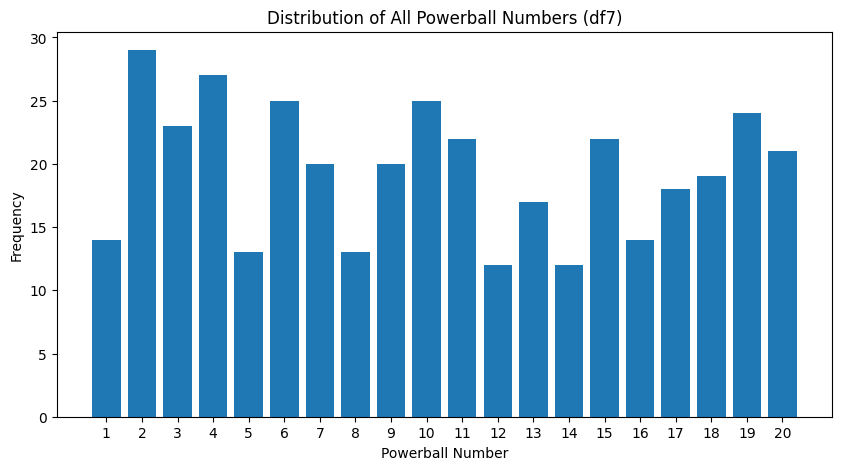

In [143]:
for pred, true in zip(y_pb_pred, y_val_pb):
    match = pred == true
    print(f"Predicted: {pred} | True: {true} | Match: {match}")

accuracy = (y_pb_pred == y_val_pb).mean()
print(f"\nPowerball prediction accuracy: {accuracy:.3f}")

Predicted: 4 | True: 12 | Match: False
Predicted: 4 | True: 1 | Match: False
Predicted: 4 | True: 14 | Match: False
Predicted: 4 | True: 16 | Match: False
Predicted: 4 | True: 2 | Match: False
Predicted: 4 | True: 11 | Match: False
Predicted: 4 | True: 19 | Match: False
Predicted: 4 | True: 18 | Match: False
Predicted: 4 | True: 8 | Match: False
Predicted: 4 | True: 5 | Match: False
Predicted: 4 | True: 10 | Match: False
Predicted: 4 | True: 17 | Match: False
Predicted: 4 | True: 18 | Match: False
Predicted: 4 | True: 2 | Match: False
Predicted: 4 | True: 18 | Match: False
Predicted: 4 | True: 20 | Match: False
Predicted: 4 | True: 17 | Match: False
Predicted: 4 | True: 11 | Match: False
Predicted: 4 | True: 10 | Match: False
Predicted: 4 | True: 4 | Match: True
Predicted: 4 | True: 19 | Match: False
Predicted: 4 | True: 18 | Match: False
Predicted: 4 | True: 10 | Match: False
Predicted: 4 | True: 15 | Match: False
Predicted: 4 | True: 6 | Match: False
Predicted: 4 | True: 2 | Match: F